In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'NEAR'
yf_crypto = 'NEAR'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2020-10-14,1.694560,1.694560,1.064818,1.185806,94692273
2020-10-15,1.177929,1.249225,1.088780,1.125557,34933419
2020-10-16,1.124601,1.151711,0.814550,0.817511,37020875
2020-10-17,0.817511,0.853755,0.727224,0.808136,23630173
2020-10-18,0.809037,0.873260,0.802059,0.871674,14376473


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,7.118687,7.465867,7.011890,7.425075,291371246
2024-06-05,7.425075,7.704233,7.424404,7.655090,263736480
2024-06-06,7.655090,7.674423,7.247033,7.333911,214474286
2024-06-07,7.333911,7.437797,6.259663,6.880046,496082106
2024-06-08,6.879250,6.901978,6.487962,6.571624,235556503


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

6.571623802185059

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.996467,0.996466,0.992757,0.741268
High,0.996467,1.000000,0.995417,0.997102,0.764171
Low,0.996466,0.995417,1.000000,0.996343,0.732232
Close,0.992757,0.997102,0.996343,1.000000,0.753586
Volume,0.741268,0.764171,0.732232,0.753586,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2020-10-14,1.185806,94692273
2020-10-15,1.125557,34933419
2020-10-16,0.817511,37020875
2020-10-17,0.808136,23630173
2020-10-18,0.871674,14376473
...,...,...
2024-06-04,7.425075,291371246
2024-06-05,7.655090,263736480
2024-06-06,7.333911,214474286


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2020-12-02,1.175250,40593260,1.086968,0.921847,0.862746
2020-12-03,1.155561,10770456,1.085515,0.941644,0.862141
2020-12-04,1.104126,19687326,1.071773,0.960641,0.861713
2020-12-05,1.112830,24940202,1.072329,0.974659,0.867619
2020-12-06,1.034688,12028258,1.075185,0.985208,0.872150


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,7.425075,291371246,7.453696,7.547876,7.138069
2024-06-05,7.655090,263736480,7.438668,7.559569,7.181178
2024-06-06,7.333911,214474286,7.390307,7.566574,7.219664
2024-06-07,6.880046,496082106,7.307790,7.568987,7.243190
2024-06-08,6.571624,235556503,7.207906,7.538498,7.262867


<Axes: xlabel='Date'>

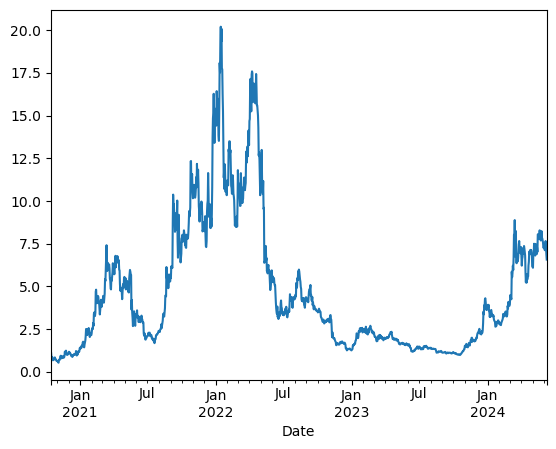

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2020-10-14,1.185806,94692273
1,2020-10-15,1.125557,34933419
2,2020-10-16,0.817511,37020875
3,2020-10-17,0.808136,23630173
4,2020-10-18,0.871674,14376473
...,...,...,...
1329,2024-06-04,7.425075,291371246
1330,2024-06-05,7.655090,263736480
1331,2024-06-06,7.333911,214474286
1332,2024-06-07,6.880046,496082106


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

16:51:08 - cmdstanpy - INFO - Chain [1] start processing
16:51:08 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
1419,2024-09-02
1420,2024-09-03
1421,2024-09-04
1422,2024-09-05
1423,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1394,2024-08-08,6.320247,3.330580,7.046669,6.012228,6.606716,-1.167867,-1.167867,-1.167867,0.041096,0.041096,0.041096,-1.208963,-1.208963,-1.208963,0.0,0.0,0.0,5.152380
1395,2024-08-09,6.333601,3.417752,6.874682,6.017953,6.629139,-1.171505,-1.171505,-1.171505,0.011261,0.011261,0.011261,-1.182766,-1.182766,-1.182766,0.0,0.0,0.0,5.162096
1396,2024-08-10,6.346955,3.529115,7.022355,6.022122,6.652692,-1.159348,-1.159348,-1.159348,0.000491,0.000491,0.000491,-1.159840,-1.159840,-1.159840,0.0,0.0,0.0,5.187607
1397,2024-08-11,6.360309,3.334868,6.928460,6.023338,6.673602,-1.150311,-1.150311,-1.150311,-0.010223,-0.010223,-0.010223,-1.140087,-1.140087,-1.140087,0.0,0.0,0.0,5.209999
1398,2024-08-12,6.373664,3.530168,6.924554,6.028919,6.695718,-1.172080,-1.172080,-1.172080,-0.048788,-0.048788,-0.048788,-1.123293,-1.123293,-1.123293,0.0,0.0,0.0,5.201583
1399,2024-08-13,6.387018,3.473822,6.975578,6.035579,6.725119,-1.116536,-1.116536,-1.116536,-0.007413,-0.007413,-0.007413,-1.109122,-1.109122,-1.109122,0.0,0.0,0.0,5.270482
1400,2024-08-14,6.400372,3.529712,7.067549,6.042239,6.744888,-1.083559,-1.083559,-1.083559,0.013576,0.013576,0.013576,-1.097135,-1.097135,-1.097135,0.0,0.0,0.0,5.316813
1401,2024-08-15,6.413726,3.598719,7.189012,6.047797,6.773586,-1.045696,-1.045696,-1.045696,0.041096,0.041096,0.041096,-1.086793,-1.086793,-1.086793,0.0,0.0,0.0,5.368030
1402,2024-08-16,6.427080,3.503347,7.246324,6.052898,6.800248,-1.066214,-1.066214,-1.066214,0.011261,0.011261,0.011261,-1.077475,-1.077475,-1.077475,0.0,0.0,0.0,5.360866
1403,2024-08-17,6.440435,3.566710,7.100660,6.055482,6.819878,-1.068009,-1.068009,-1.068009,0.000491,0.000491,0.000491,-1.068500,-1.068500,-1.068500,0.0,0.0,0.0,5.372425


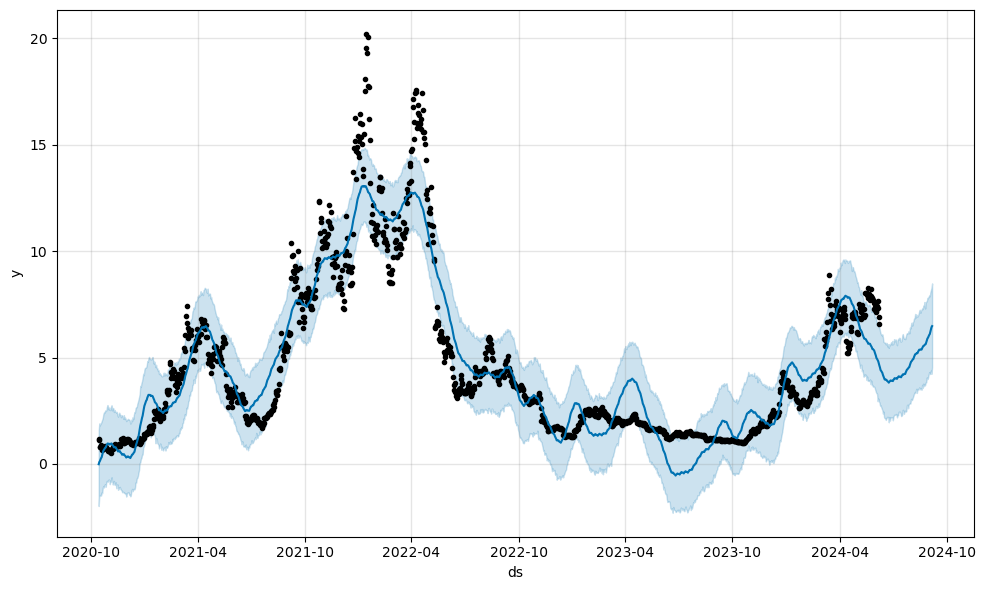

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,4.526557,2.743658,6.245512
2024-06-10,4.408609,2.756532,6.133575
2024-06-11,4.373203,2.674633,6.077710
2024-06-12,4.320833,2.597732,6.037880
2024-06-13,4.279175,2.528670,6.090369
...,...,...,...
2024-09-02,6.098604,4.222311,7.875579
2024-09-03,6.219695,4.248501,8.067160
2024-09-04,6.320794,4.387709,8.171208


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

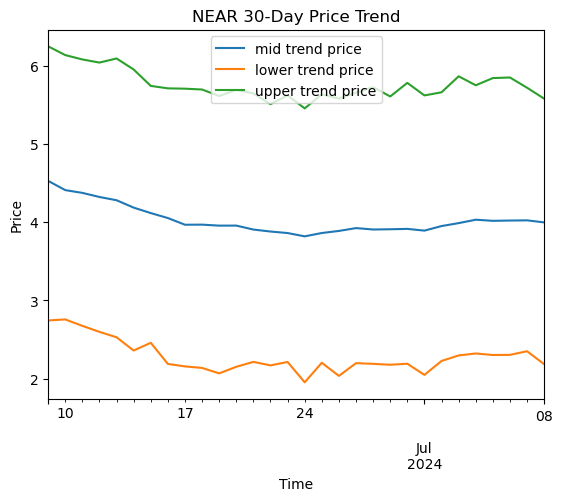

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

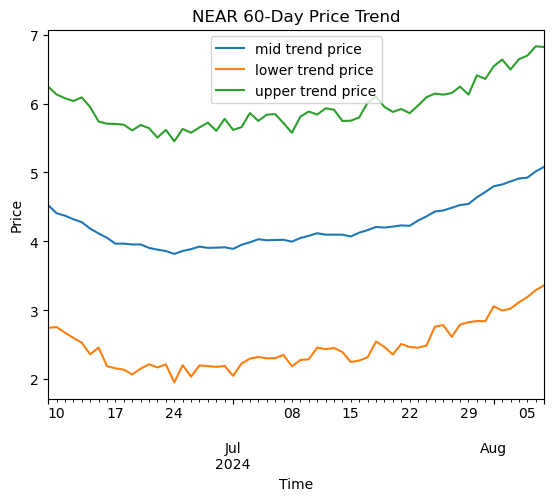

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

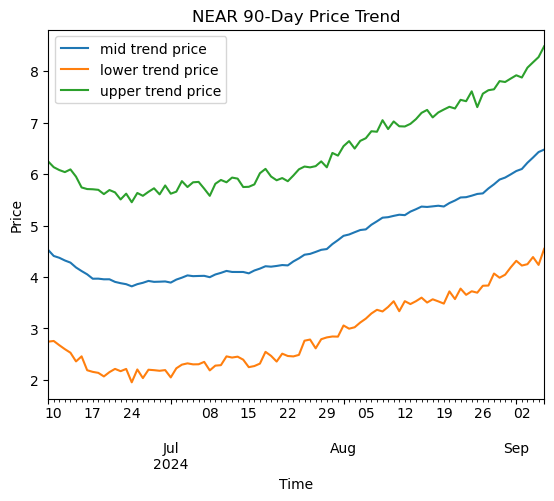

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')   
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

6.571623802185059

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

4.526557203193377

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

5.549090502689218

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

4.513768220903886

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

4.047063955829322

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

5.166877851106266

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

6.490915583437146

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.271

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.069

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.17

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

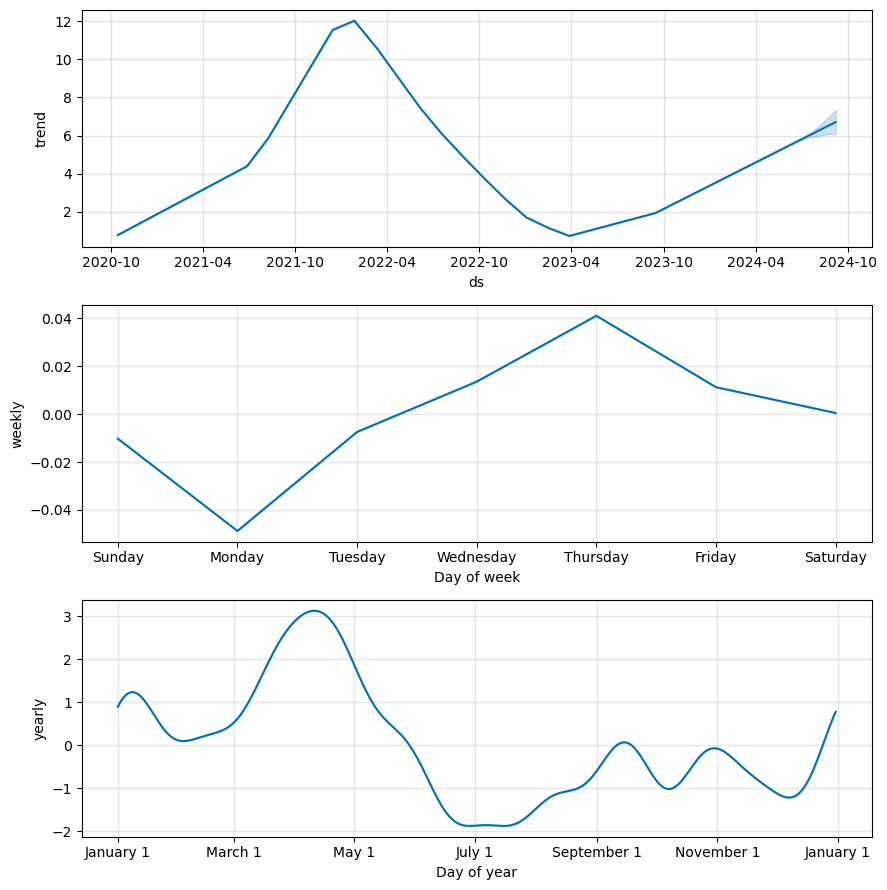

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

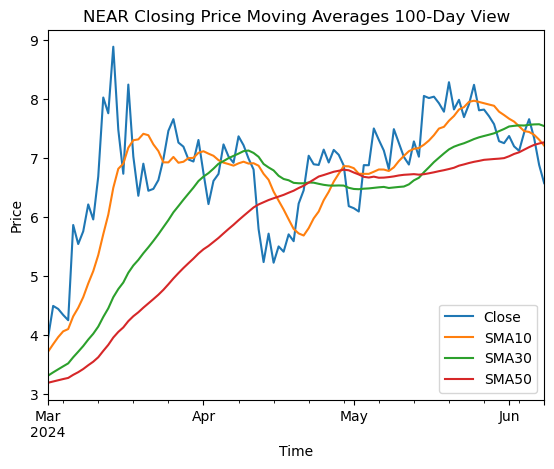

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

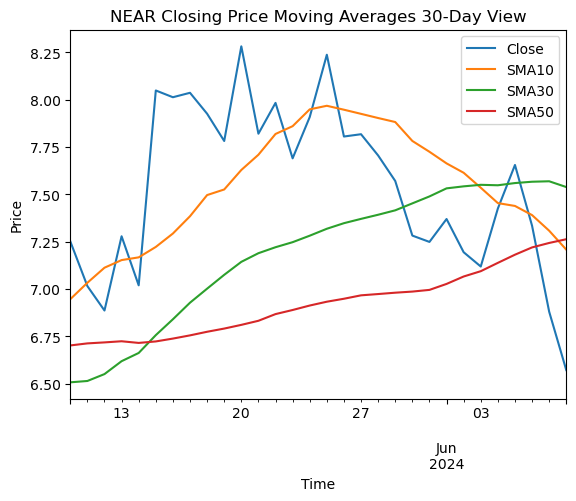

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629
AVAX,32.29003143310547,-0.061383912293528464,0.006255814491331391,0.188757389641659
BNB,682.6651611328125,-0.25945675235825627,-0.21619087415535265,-0.19462572272913758
BONK,2.700000004551839e-05,0.19694570130627698,0.3277996886564134,0.4415377509818921
BTC,69305.7734375,-0.1351637782567381,-0.09261706566887273,-0.09372540555309616
DOGE,0.14605900645256042,-0.18446710000937716,-0.08920949588743987,-0.03966410323402325
ETH,3680.949951171875,-0.11161221692021561,-0.03134563847923688,-0.